In [2]:
include("model_2D_IB.jl")

using SparseIR, Plots
#using OMEinsum
#using FastGaussQuadrature
import SparseIR: valueim, value
import SparseIR: fit

In [3]:
struct IR_params
    U::Float64
    beta::Float64
    bw::Float64
    basis::FiniteTempBasis
    #{Fermionic, LogisticKernel, Float64, Float64}
    
    smpl_matsu::MatsubaraSampling64F
    smpl_tau::TauSampling64

    n_matsu::Int
    n_tau::Int

    smpl_wn::Vector{ComplexF64}
end

function set_IR(U::Float64, beta::Float64, bw::Float64)
    basis = FiniteTempBasis(Fermionic(), beta, bw, 1e-10)

    smpl_matsu = MatsubaraSampling(basis)
    n_matsu = size(smpl_matsu.sampling_points)[1]

    smpl_tau = TauSampling(basis)
    n_tau = size(smpl_tau.sampling_points)[1]

    smpl_wn = zeros(ComplexF64, n_matsu)
    for w in 1:n_matsu
        smpl_wn[w] = valueim(smpl_matsu.sampling_points[w], beta)
    end

    return U, beta, bw, basis, smpl_matsu, smpl_tau, n_matsu, n_tau, smpl_wn
end

mutable struct Green_Sigma
    g0_ir::Vector{Matrix{ComplexF64}}
    g0_ir_vec::Matrix{Float64}
    g0_tau::Vector{Matrix{ComplexF64}}
    g0_matsu::Vector{Matrix{ComplexF64}}

    g_ir::Vector{Matrix{ComplexF64}}
    g_ir_vec::Matrix{Float64}
    g_matsu::Vector{Matrix{ComplexF64}}

    sigma_ir::Vector{Matrix{ComplexF64}}
    sigma_tau::Vector{Matrix{ComplexF64}}
    sigma_matsu::Vector{Matrix{ComplexF64}}

    n_ir::Int
end

function init_zero_g(ir::IR_params)
    
    g0_ir::Vector{Matrix{ComplexF64}} = []
    g0_ir_vec = zeros(Float64, 43, 4)
    g0_tau::Vector{Matrix{ComplexF64}} = []
    g0_matsu::Vector{Matrix{ComplexF64}} = []

    g_ir::Vector{Matrix{ComplexF64}} = []
    g_ir_vec = zeros(Float64, 43, 4)
    g_matsu::Vector{Matrix{ComplexF64}} = []

    sigma_ir::Vector{Matrix{ComplexF64}} = []
    sigma_tau::Vector{Matrix{ComplexF64}} = []
    sigma_matsu::Vector{Matrix{ComplexF64}} = []

    n_ir::Int = 0

    return g0_ir, g0_ir_vec, g0_tau, g0_matsu, g_ir, g_ir_vec, g_matsu, sigma_ir, sigma_tau, sigma_matsu, n_ir
end


function gk_m(p::Parm, k::Vector{Float64}, w::ComplexF64, g::Green_Sigma)
    e = set_H(k,p)
    gk = 1.0/(w - e - g.sig)
    return gk
end


gk_m (generic function with 1 method)

In [4]:
px = Parm(set_parm(["0.5","0.2","0.3", "-2.0", "0.05", "200"])...)
irx = IR_params(set_IR(4.0, 100.0, 4.0)...)
gx = Green_Sigma(init_zero_g(irx)...)
println(px)

Parm(0.5, 0.2, 0.3, -2.0, 0.05, 200, 2.5e-5)


In [5]:

function get_G0mlocal!(p::Parm, k_BZ::Vector{Vector{Float64}}, sw::Int,ir::IR_params, g::Green_Sigma)
    if(sw == 1)
        for wn in 1:ir.n_matsu
            gw_l = zeros(ComplexF64, 2, 2)
            gl = zeros(ComplexF64, 2, 2)
            for i in 1:length(k_BZ)
                e = set_H(k_BZ[i],p) - p.mu*Matrix{Complex{Float64}}(I,2,2)
                #gk = 1.0/(w - e + p.eta*1.0im*sign(imag(w)))
                gk = inv(ir.smpl_wn[wn]*Matrix{Complex{Float64}}(I,2,2) - e)
                gw_l += p.dk2 * gk
            end
            push!(g.g0_matsu, gw_l)
            push!(g.g_matsu, gl)
        end
    else
        for wn in 1:ir.n_matsu
            gw_l = zeros(ComplexF64, 2, 2)
            gl = zeros(ComplexF64, 2, 2)
            for i in 1:length(k_BZ)
                e = set_H(k_BZ[i],p) - p.mu*Matrix{Complex{Float64}}(I,2,2)
                #gk = 1.0/(w - e + p.eta*1.0im*sign(imag(w)))
                gk = inv(ir.smpl_wn[wn]*Matrix{Complex{Float64}}(I,2,2) - e - g.sigma_matsu[wn])
                gl += p.dk2 * gk
            end
            gw_l = inv(inv(gl) + g.sigma_matsu[wn])
            g.g0_matsu[wn] = gw_l
            g.g_matsu[wn] = gl
        end
    end
    return nothing
end

get_G0mlocal! (generic function with 1 method)

In [6]:
function MatsuToTau!(ir::IR_params, g::Green_Sigma)
    g.g0_ir = fit(ir.smpl_matsu, g.g0_matsu, dim=1)
    g.g_ir = fit(ir.smpl_matsu, g.g_matsu, dim=1)
    g.n_ir = size(g.g0_ir)[1]
    g.g0_tau = evaluate(ir.smpl_tau, g.g0_ir, dim=1)
end

MatsuToTau! (generic function with 1 method)

In [7]:
kk = get_kk(px.K_SIZE)
get_G0mlocal!(px, kk, 1, irx, gx)
    #MatsuToTau!(ir, g)

In [8]:
MatsuToTau!(irx, gx)
println("done!")

done!


In [9]:
gx.n_ir

43

In [10]:
function calc_sigma!(sw::Int, ir::IR_params, g::Green_Sigma)
    for tau in 1:ir.n_tau
        if(sw == 1)
            test = zeros(ComplexF64, 2, 2)
            for i in 1:2, j in 1:2 
                test[i,j] = ir.U^2 * (g.g0_tau[tau])[i,j] * (g.g0_tau[tau])[3-i,3-j] * (g.g0_tau[end+1-tau])[3-i,3-j]
                #test[i,j] = ir.U^2 * (g.g0_tau[tau])[i,j] * (g.g0_tau[tau])[i,j] * (g.g0_tau[end+1-tau])[i,j]
            end
            push!(g.sigma_tau, test)
        else
            for i in 1:2, j in 1:2 
                (g.sigma_tau[tau])[i,j] = ir.U^2 * (g.g0_tau[tau])[i,j] * (g.g0_tau[tau])[3-i,3-j] * (g.g0_tau[end+1-tau])[3-i,3-j]
                #(g.sigma_tau[tau])[i,j] = ir.U^2 * (g.g0_tau[tau])[i,j] * (g.g0_tau[tau])[i,j] * (g.g0_tau[end+1-tau])[i,j]
            end
        end
    end
    return nothing
end

calc_sigma! (generic function with 1 method)

In [11]:
calc_sigma!(1, irx, gx)

In [12]:
function TauToMatsu!(sw::Int, ir::IR_params, g::Green_Sigma, γ::Float64)
    ir_new = fit(ir.smpl_tau, g.sigma_tau)
    diff0 =0.0
    sum0 = 0.0
    if(sw == 1)
        for i in 1:g.n_ir
            diff0 += sum(abs.(ir_new[i]))
            push!(g.sigma_ir, zeros(ComplexF64, 2, 2))
        end
        sum0 = 1.0
    else
        for i in 1:g.n_ir
            diff0 += sum(abs.(ir_new[i] .- g.sigma_ir[i]))
            sum0 += sum(abs.(g.sigma_ir[i]))
        end
    end
    diff = diff0/sum0
    g.sigma_ir = (1.0-γ) .* g.sigma_ir .+ γ .* ir_new
    g.sigma_matsu = evaluate(ir.smpl_matsu, g.sigma_ir, dim=1)

    return diff
end

TauToMatsu! (generic function with 1 method)

In [13]:
diff = TauToMatsu!(1, irx, gx, 0.2)

6.367193908753284

In [14]:
function update_g!(p::Parm, k_BZ::Vector{Vector{Float64}},sw::Int, ir::IR_params, g::Green_Sigma, γ::Float64)
    get_G0mlocal!(p, k_BZ, sw, ir, g)
    MatsuToTau!(ir, g)
    calc_sigma!(sw, ir, g)
    # .+ ir.U .* g.g0_tau
    diff = TauToMatsu!(sw, ir, g, γ)
    return diff
end

update_g! (generic function with 1 method)

In [15]:
for it in 2:1000
    L1 = update_g!(px,kk,it,irx,gx, 0.2)
    if(L1<1e-7)
        println(it)
        break
    end
end

81


In [22]:
function MtoV!(g::Green_Sigma)
    g.g0_ir_vec = zeros(Float64, g.n_ir, 4)
    g.g_ir_vec = zeros(Float64, g.n_ir, 4)
    for it in 1:g.n_ir
        for mm in 1:4
            g.g0_ir_vec[it,mm] = real(tr(sigma[mm]*g.g0_ir[it]))/2
            g.g_ir_vec[it,mm] = real(tr(sigma[mm]*g.g_ir[it]))/2
        end
    end
end

MtoV! (generic function with 1 method)

In [23]:
MtoV!(gx)

In [25]:
gx.g0_ir_vec[2,:]

4-element Vector{Float64}:
 -1.9061641154394238e-11
 -4.627479060432188e-17
 -2.5774440282693543e-19
  0.6776410033852819

In [30]:
function F_rho(ir::IR_params, g::Green_Sigma, rho_ls, λ)
    #vec::Vector{Matrix{ComplexF64}} = []
    vec = g.g_ir_vec - (ir.basis.s .* rho_ls)
    #=vec = zeros(Float64, g.n_ir, 4)
    for i in 1:g.n_ir
        test = g.g_ir_vec[i] - ir.basis.s[i] * (rho_ls[i,:]' * sigma)
        push!(vec, test)
    end
    f = 0.0
    for i in 1:g.n_ir
        f += 0.5*real(sum(abs.((vec[i])'*vec[i]))) + λ*sum(abs.(rho_ls[i]))
    end=#
    return f = 0.5*sum((vec.^2)) + λ*sum(abs.(rho_ls))
end

F_rho (generic function with 1 method)

In [28]:
testm = rand(Float64, gx.n_ir, 4)

43×4 Matrix{Float64}:
 0.436605   0.954257    0.929473    0.913241
 0.788514   0.696895    0.472924    0.526256
 0.326809   0.517553    0.862117    0.605736
 0.211879   0.241286    0.284008    0.924883
 0.501329   0.260363    0.0631385   0.525095
 0.83362    0.424121    0.198255    0.690617
 0.249052   0.00771204  0.644888    0.0794197
 0.789887   0.421632    0.48051     0.817133
 0.936573   0.270528    0.300669    0.340716
 0.250777   0.764035    0.517853    0.161304
 0.889651   0.588655    0.0375627   0.779875
 0.194588   0.35615     0.722702    0.499188
 0.353793   0.134418    0.312163    0.533961
 ⋮                                  
 0.231523   0.795159    0.00526082  0.0547728
 0.323236   0.573755    0.0241567   0.553438
 0.914351   0.105774    0.311697    0.533854
 0.78493    0.267466    0.569519    0.396438
 0.615437   0.586836    0.872939    0.795205
 0.269602   0.640701    0.899007    0.616103
 0.817364   0.933638    0.663632    0.913765
 0.0060969  0.276458    0.496283    0.1

In [31]:
fff = F_rho(irx, gx, testm, 0.0001)

6.712794875798384

In [35]:
using Flux

In [45]:
function fit_rhow(ir::IR_params, g::Green_Sigma, l_num::Int, batch_num::Int, w_mesh::Vector{Float64})
    sn = range(-12.0, 0.0, length=l_num)
    lam_test = 10 .^ (sn)
    opt = ADAM()
    s_rho_l::Vector{Matrix{Float64}} = []
    #rand(Float64, l_num, g.n_ir)
    s_F_rho = 1000.0 * ones(Float64, l_num)
    for ll in 1:l_num
        lam = lam_test[ll]
        count::Int = 0
        for b in 1:batch_num
            rho_ll = rand(Float64, g.n_ir, 4)
            
            #rho_ll = rand(Float64, g.n_ir)
            F_old = 1000.0
            F_new = 1000.0
            for i in 1:8000
                grads = Flux.gradient(Flux.params(rho_ll)) do
                    F_rho(ir, g, rho_ll, lam)
                end
                Flux.Optimise.update!(opt, Flux.params(rho_ll), grads)
                F_old = F_new
                F_new = F_rho(ir, g, rho_ll, lam)
                if(abs(F_old-F_new)/abs(F_old)<1e-6)
                    break
                end
                if(i==8000)
                    count += 1
                end
            end
            if(s_F_rho[ll] > F_new)
                if(b==1)
                    push!(s_rho_l, rho_ll)
                else
                    s_rho_l[ll] = rho_ll
                end
                s_F_rho[ll] = F_new
            end 
        end
        println(count)
    end
    b = (log(s_F_rho[end])-log(s_F_rho[1]))/(log(lam_test[end])-log(lam_test[1]))
    a = s_F_rho[1]*lam_test[1]^(-b)
    ev = a .* lam_test .^ b ./ s_F_rho

    p1 = plot(lam_test, ev, xaxis=:log, yaxis=:log, marker=:circle)
    #savefig(p1,"./lambda_opt_G.png")

    it = findmax(ev)[2]+1
    max1 = s_F_rho[it]
    println("it:$it,  s_F:$max1")
    rho_omega = -(transpose(ir.basis.v(w_mesh)) * s_rho_l[it])
    return rho_omega
end

fit_rhow (generic function with 1 method)

In [33]:
lamda_num = 20
batch_num = 100
w_num = 500
w_mesh = collect(-irx.bw:2irx.bw/(w_num-1):irx.bw)
println("I'm ready!")

I'm ready!


In [46]:
gi = fit_rhow(irx, gx, lamda_num, batch_num, w_mesh)

78
66
64
56
66
10
0
0
0
0
0
0
0
1
0
0
1
4
4
30
it:7,  s_F:1.2680094059607285e-8


500×4 Matrix{Float64}:
 0.0104101    0.000160147   3.19098e-5    0.0293089
 0.00951093   0.000167025   3.95696e-5    0.0278961
 0.00864827   0.000168587   4.28706e-5    0.0264723
 0.0078232    0.000165665   4.24857e-5    0.0250396
 0.0070368    0.00015902    3.90344e-5    0.0235997
 0.0062901    0.000149349   3.30851e-5    0.0221541
 0.00558405   0.00013728    2.51568e-5    0.0207045
 0.00491957   0.000123384   1.57214e-5    0.0192522
 0.0042975    0.00010817    5.20555e-6    0.0177984
 0.00371863   9.20936e-5   -6.00716e-6    0.0163443
 0.00318371   7.5559e-5    -1.75742e-5    0.0148909
 0.00269341   5.892e-5     -2.91923e-5    0.0134391
 0.00224839   4.24846e-5   -4.0595e-5     0.0119898
 ⋮                                       
 0.0024916    7.52548e-5   -7.65257e-7   -0.0134241
 0.00299917   7.12394e-5   -6.30745e-6   -0.0148469
 0.00355905   6.47609e-5   -1.34322e-5   -0.0162738
 0.00417157   5.54141e-5   -2.24208e-5   -0.017705
 0.00483708   4.27504e-5   -3.35823e-5   -0.0191409


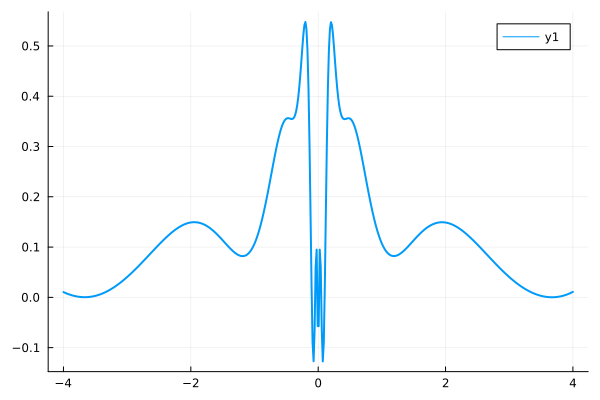

In [47]:
plot(w_mesh, gi[:,1], linewidth=2.0)